# Demo of K-means Clustering Using Various Cost Metrics
### Author: Daniel Wang

For cost metrics other than "squared_euclidean", the centroids are computed using an iterative algorithm. This may take a while.


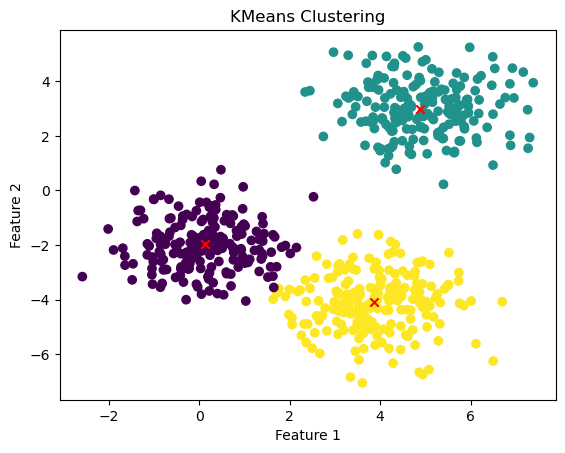

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from kmeans import KMeans

# Generate a synthetic dataset
np.random.seed(0)
n_samples = 200
n_features = 2
n_clusters = 3

X = np.concatenate((
    np.random.randn(n_samples, n_features) + [5, 3],
    np.random.randn(n_samples, n_features) + [4, -4],
    np.random.randn(n_samples, n_features) + [0, -2]
))

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=n_clusters, max_iter=500)
kmeans.fit(X, cost_metric='euclidean', tolerance=1e-6, max_steps=100)

# Plot the data points and centroids
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels, cmap='viridis')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x', zorder=10)
plt.title("KMeans Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
